# Descripción

La mision espacial Kepler ha buscado exoplanetas (planetas fuera de nuestro sistema solar) durante la última década. Los candidatos a exoplanetas se analizan corroboran mediante distintos procesos. Teniendo una base de planetas ya etiquetados, se vuelve posible usar técnicas de ML para automatizar el proceso.

El objetivo de éste codigo es construir un un modelo de ML que detecte los planetas confirmados.

## Libraries dependencies

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.warn('DelftStack')
warnings.warn('Do not show this message')
print("No Warning Shown")

from time import time
from numpy import argmax
from pandas import read_csv
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
import statistics
import itertools
from itertools import combinations
from plotnine import *
import seaborn as sns


## Pre-processing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf


## Metrics
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, accuracy_score, precision_recall_curve, roc_curve, roc_auc_score

## Keras from tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout


from scikeras.wrappers import KerasClassifier


## Regularizer
from tensorflow.keras.regularizers import L1

## Optimizer
from tensorflow.keras.optimizers import Adam
from keras.optimizers import SGD
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc

No Warning Shown


In [2]:
def plot_history(history, width=12, height=6):
  """
  DESCRIPTION:
    History performance of the keras model
  
  INPUT:
    @param history: history of performance of fitted model
    @type history: tensorflow.python.keras.callbacks.History

  OUTPUT:
    A graphic
  """

  ## Metrics keys stored in tensorflow object
  keys = list(history.history.keys())

  ## Number of epoch used for fit the model
  epoch = range(1, len(history.epoch) +1)

  ## Check if validation set was used.
  withValidation = False
  for key in keys:
    if 'val' in key:
      withValidation = True

  ## Number of metrics 
  nMetrics = len(keys)
  if withValidation:
    nMetrics = nMetrics//2

  ## Plot-space instance
  plt.figure(figsize=(width, height))

  for i in range(nMetrics):
    plt.subplot(nMetrics, 1, i+1)

    ## Plot (train) metric value
    labelMetric = keys[i]
    metric = history.history[keys[i]]
    plt.plot(epoch, metric, 'o-', label=labelMetric)

    if withValidation:
      ## Plot (validation) metric value
      labelMetricVal = keys[i+nMetrics]
      metricVal = history.history[keys[i+nMetrics]]
      plt.plot(epoch, metricVal, 'o-', label=labelMetricVal)

    plt.xlim(epoch[0], epoch[-1])
    plt.legend()
    plt.grid()

  plt.xlabel('Epoch')
  plt.show()


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [3]:
# Se cargan los datos

exoplanets = pd.read_csv("exoplanets.csv")
exoplanets.head()


,koi_disposition,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
0,CONFIRMED,0,0,0,0,54.418383,2.479000e-04,-2.479000e-04,162.513840,0.003520,...,-81,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,NO EXOPLANETS,0,1,0,0,19.899140,1.490000e-05,-1.490000e-05,175.850252,0.000581,...,-176,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
2,NO EXOPLANETS,0,1,0,0,1.736952,2.630000e-07,-2.630000e-07,170.307565,0.000115,...,-174,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.285210,15.597
3,CONFIRMED,0,0,0,0,2.525592,3.760000e-06,-3.760000e-06,171.595550,0.001130,...,-211,4.438,0.070,-0.210,1.046,0.334,-0.133,288.75488,48.226200,15.509
4,CONFIRMED,0,0,0,0,4.134435,1.050000e-05,-1.050000e-05,172.979370,0.001900,...,-232,4.486,0.054,-0.229,0.972,0.315,-0.105,296.28613,48.224670,15.714


In [4]:
exoplanets.loc[exoplanets['koi_disposition'] == 'FALSE POSITIVE', 'koi_disposition'] = 'NO EXOPLANETS'

In [5]:
# Tabla de frecuencia target
table = pd.crosstab(index=exoplanets['koi_disposition'], columns='count')
table

col_0,count
koi_disposition,
CANDIDATE,1687
CONFIRMED,1800
NO EXOPLANETS,3504


In [6]:
# Promedios según target
grouped_data = exoplanets.groupby('koi_disposition')
grouped_data.mean() # Sí se observan diferencias en promedio entre los planetas confirmados y falsos positivos 

,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,...,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
koi_disposition,,,,,,,,,,,,,,,,,,,,,
CANDIDATE,0.000000,0.013041,0.000000,0.000000,67.335777,0.002160,-0.002160,169.812894,0.013236,-0.013236,...,-152.768820,4.324881,0.114910,-0.143963,1.645402,0.335579,-0.340695,291.741747,43.951164,14.361218
CONFIRMED,0.009444,0.011667,0.003333,0.000556,26.451343,0.000190,-0.000190,156.532602,0.004084,-0.004084,...,-124.126111,4.409676,0.090547,-0.106618,1.068651,0.177139,-0.150436,290.929260,44.389829,14.339791
NO EXOPLANETS,0.308505,0.476027,0.403253,0.249144,66.103066,0.002556,-0.002556,166.012645,0.010165,-0.010165,...,-184.317922,4.241754,0.139757,-0.156198,2.131909,0.451149,-0.533944,292.838786,43.448455,14.193240


In [7]:
exoplanets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6991 entries, 0 to 6990
Data columns (total 41 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   koi_disposition    6991 non-null   object 
 1   koi_fpflag_nt      6991 non-null   int64  
 2   koi_fpflag_ss      6991 non-null   int64  
 3   koi_fpflag_co      6991 non-null   int64  
 4   koi_fpflag_ec      6991 non-null   int64  
 5   koi_period         6991 non-null   float64
 6   koi_period_err1    6991 non-null   float64
 7   koi_period_err2    6991 non-null   float64
 8   koi_time0bk        6991 non-null   float64
 9   koi_time0bk_err1   6991 non-null   float64
 10  koi_time0bk_err2   6991 non-null   float64
 11  koi_impact         6991 non-null   float64
 12  koi_impact_err1    6991 non-null   float64
 13  koi_impact_err2    6991 non-null   float64
 14  koi_duration       6991 non-null   float64
 15  koi_duration_err1  6991 non-null   float64
 16  koi_duration_err2  6991 

## Data pre-processing



In [8]:
## Predictors and target assignment
X = exoplanets.drop(columns=['koi_disposition'])
y = exoplanets['koi_disposition']


## Partition sets
X_train, X_test, y_train, y_test = train_test_split(X, y)

## Standardizing
scale = MinMaxScaler().fit(X_train)
X_train = scale.transform(X_train)
X_test = scale.transform(X_test)


Y_str = y_train.values

# Convertir "labels" de caracteres a números
encoder = LabelEncoder()
encoder.fit(Y_str)
Y_num = encoder.transform(Y_str)

#  "one-hot", requerida por Keras

n_clases = 3
y_train = tf.keras.utils.to_categorical(Y_num,n_clases)

Y_num = encoder.transform(y_test)
y_test = tf.keras.utils.to_categorical(Y_num,n_clases)

## Display data shape
print('(train shape) X: {}, y: {}'.format(X_train.shape, y_train.shape))
print('(test shape) X: {}, y: {}'.format(X_test.shape, y_test.shape))

(train shape) X: (5243, 40), y: (5243, 3)
(test shape) X: (1748, 40), y: (1748, 3)


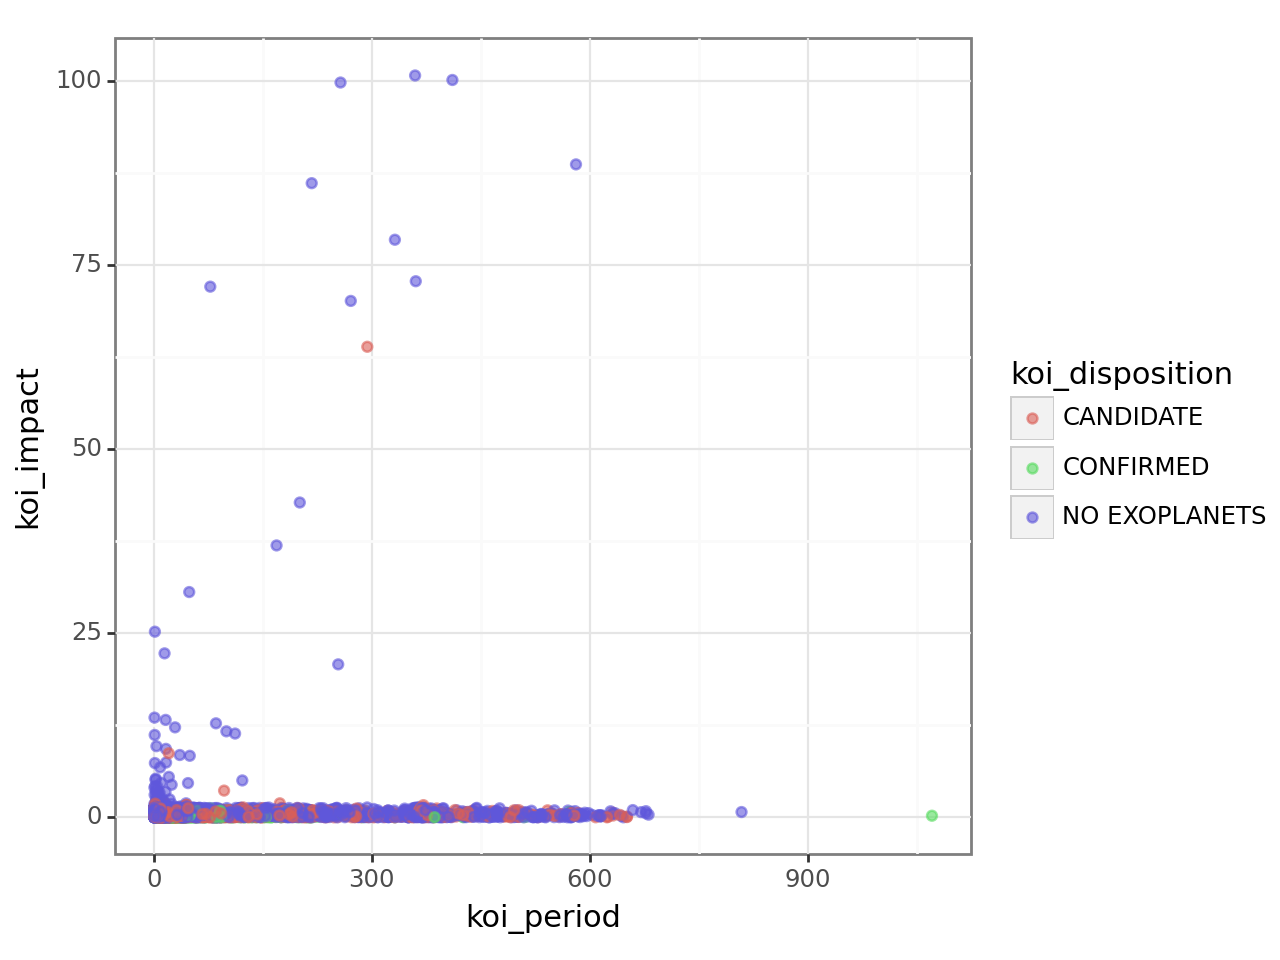

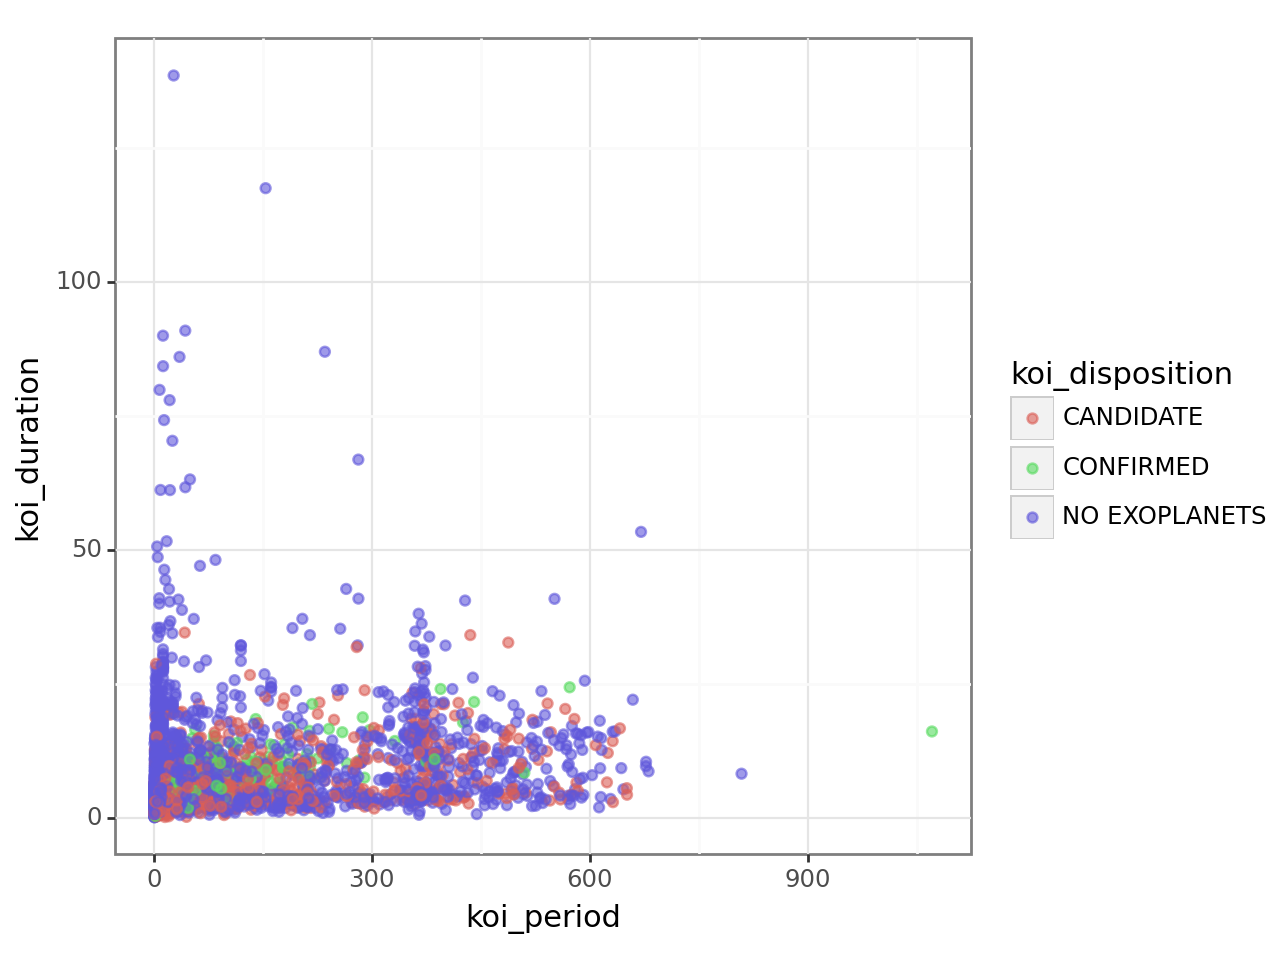

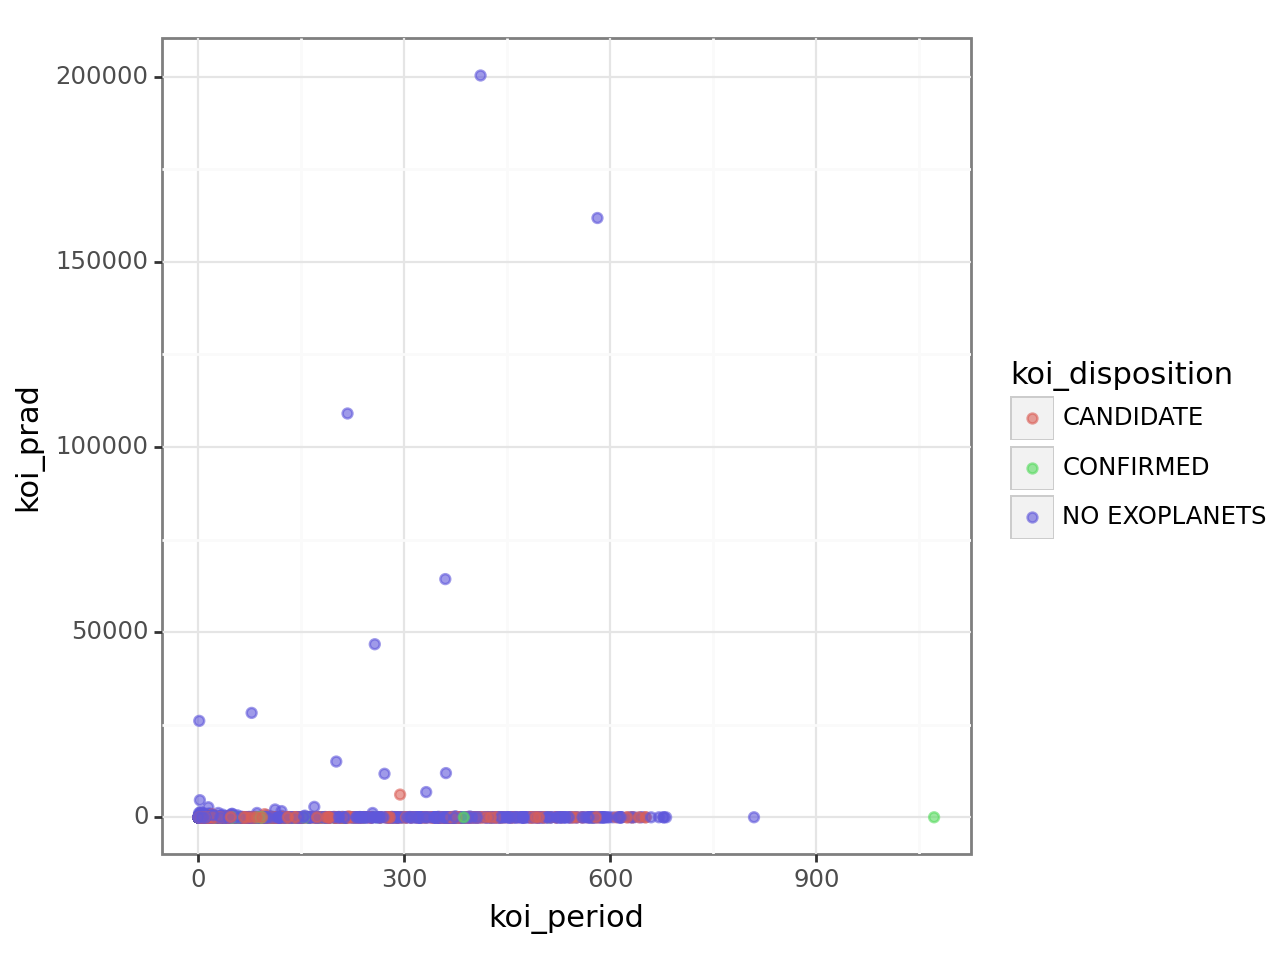

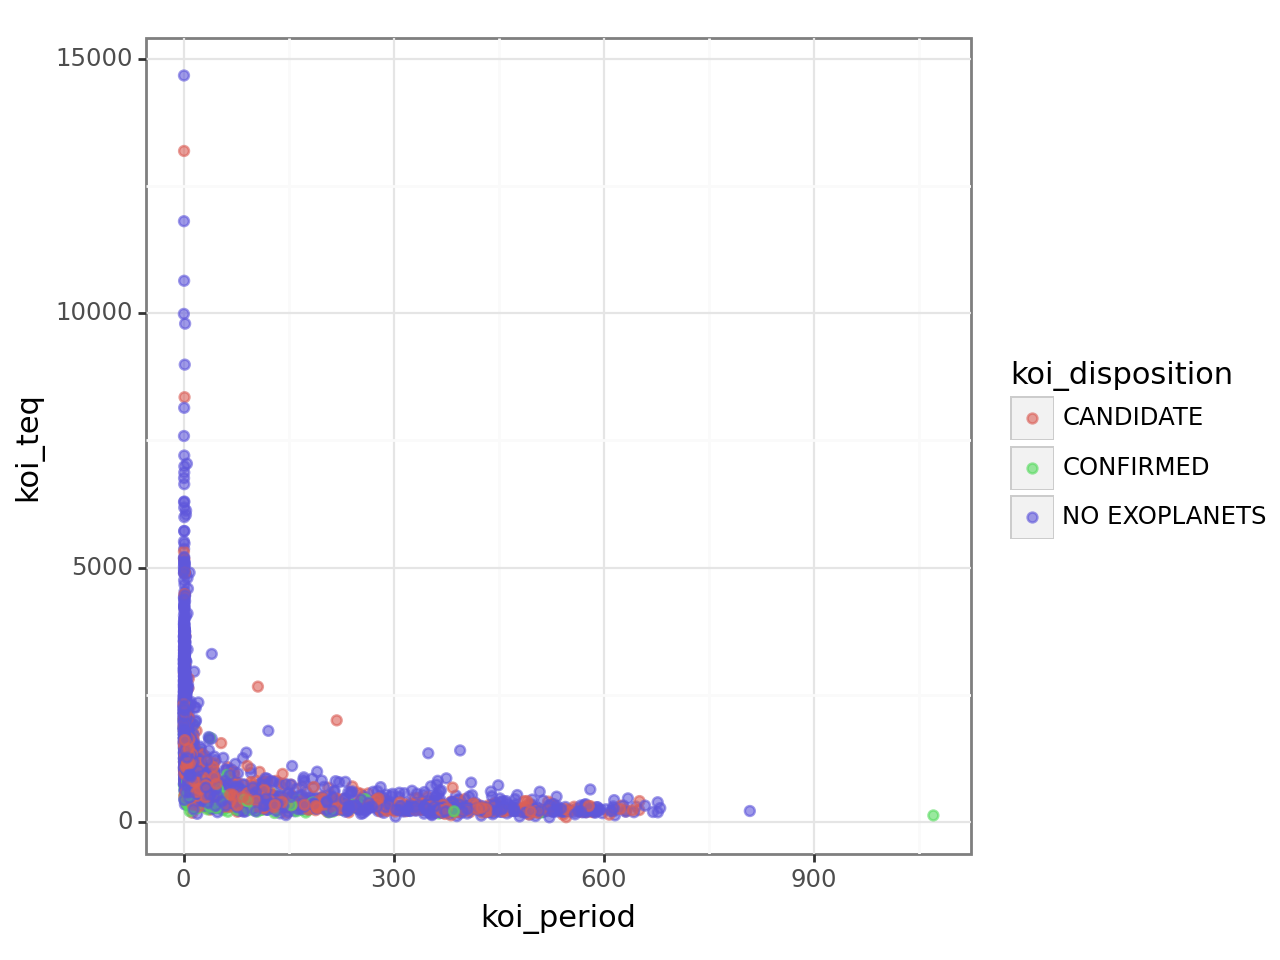

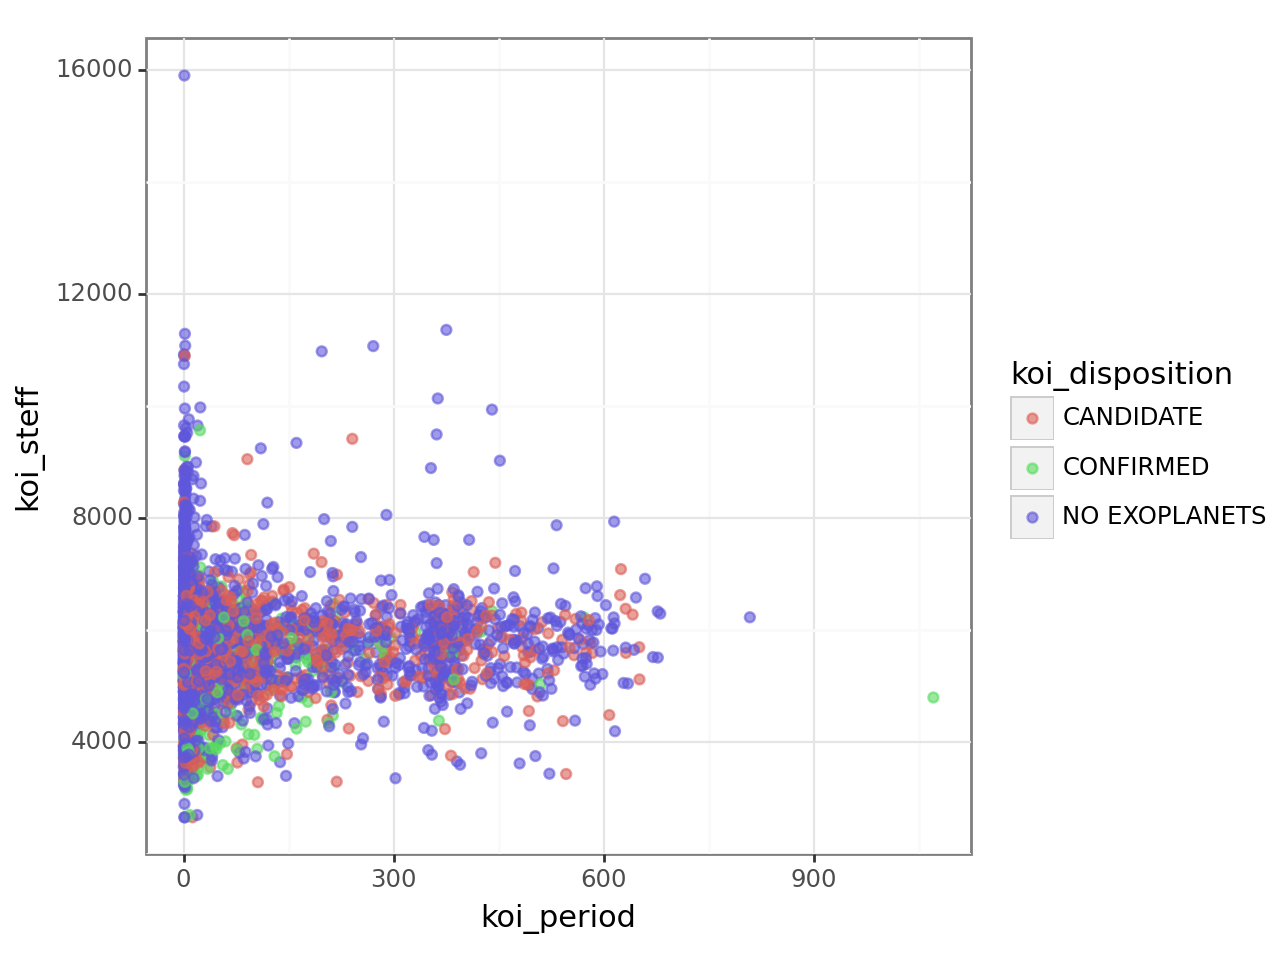

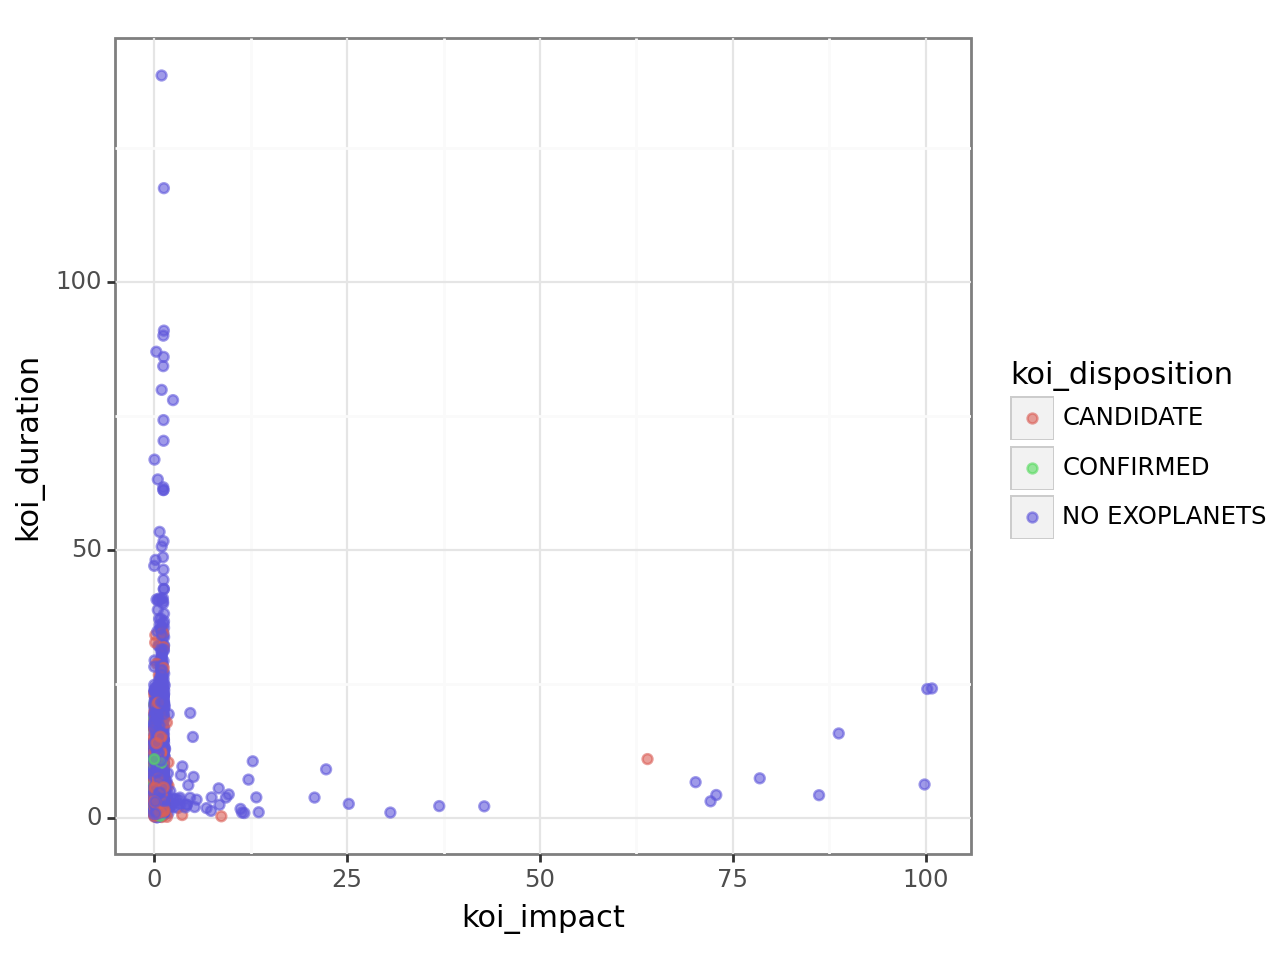

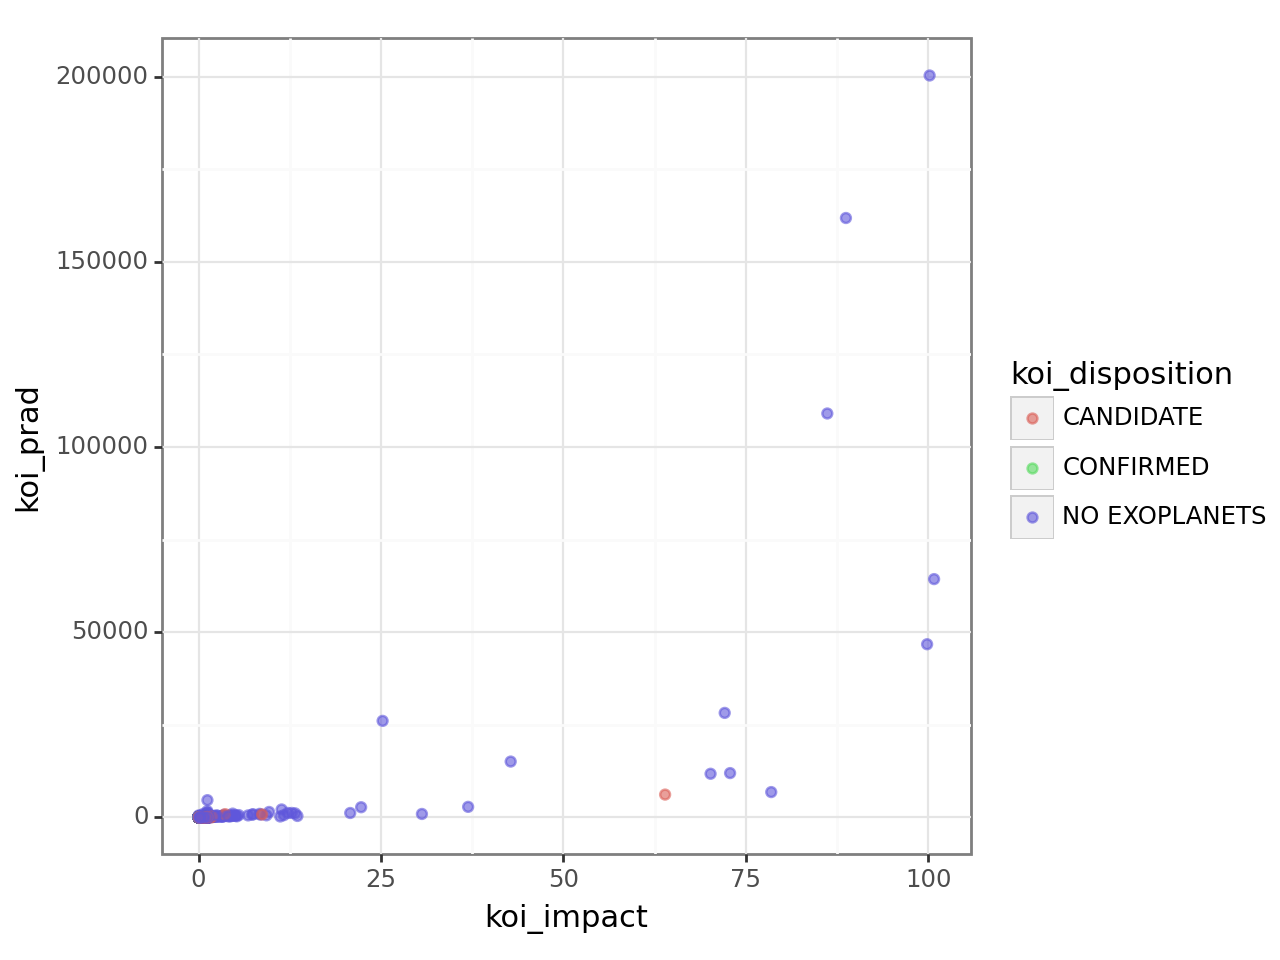

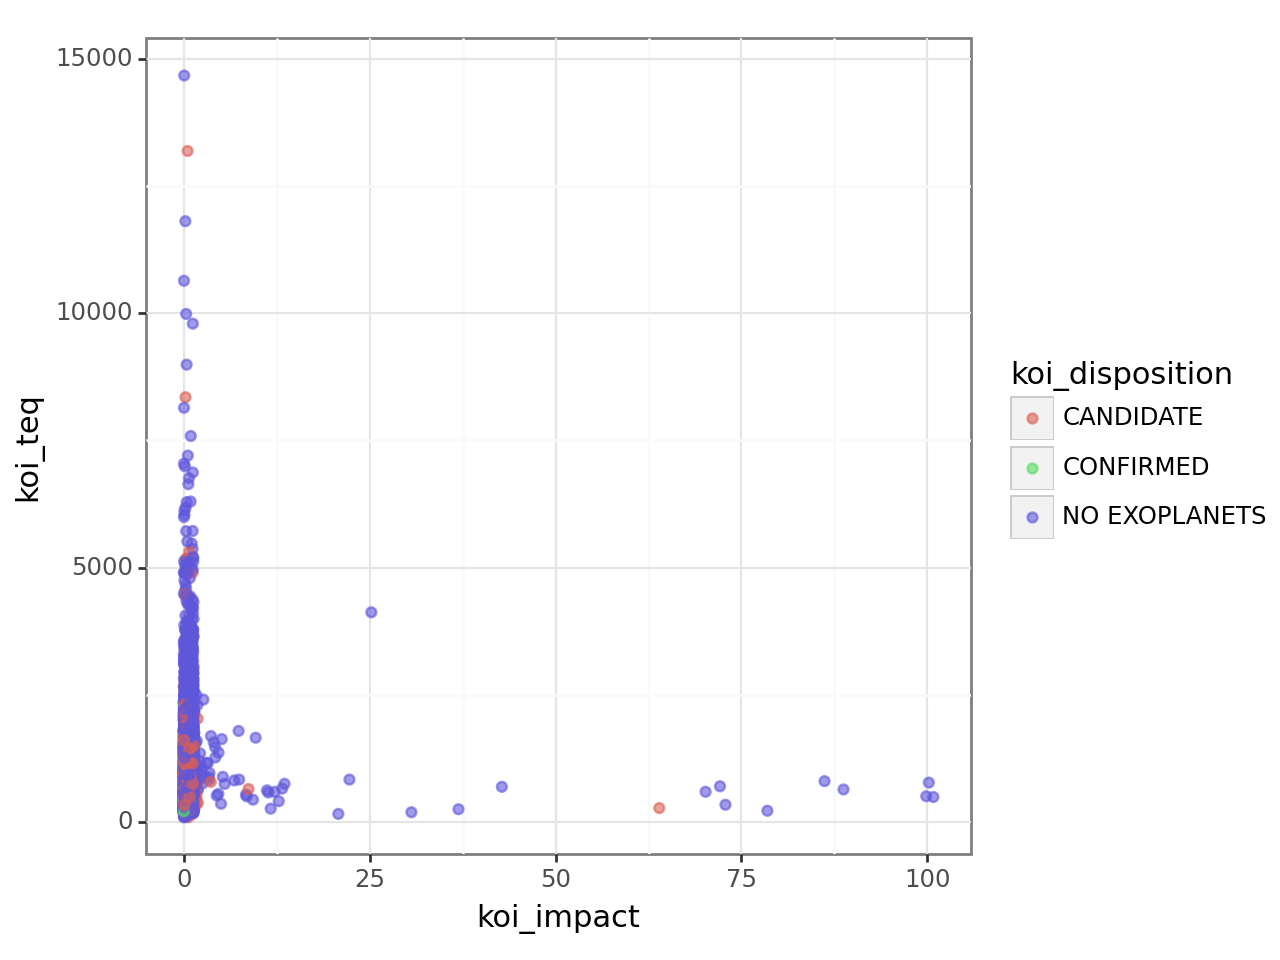

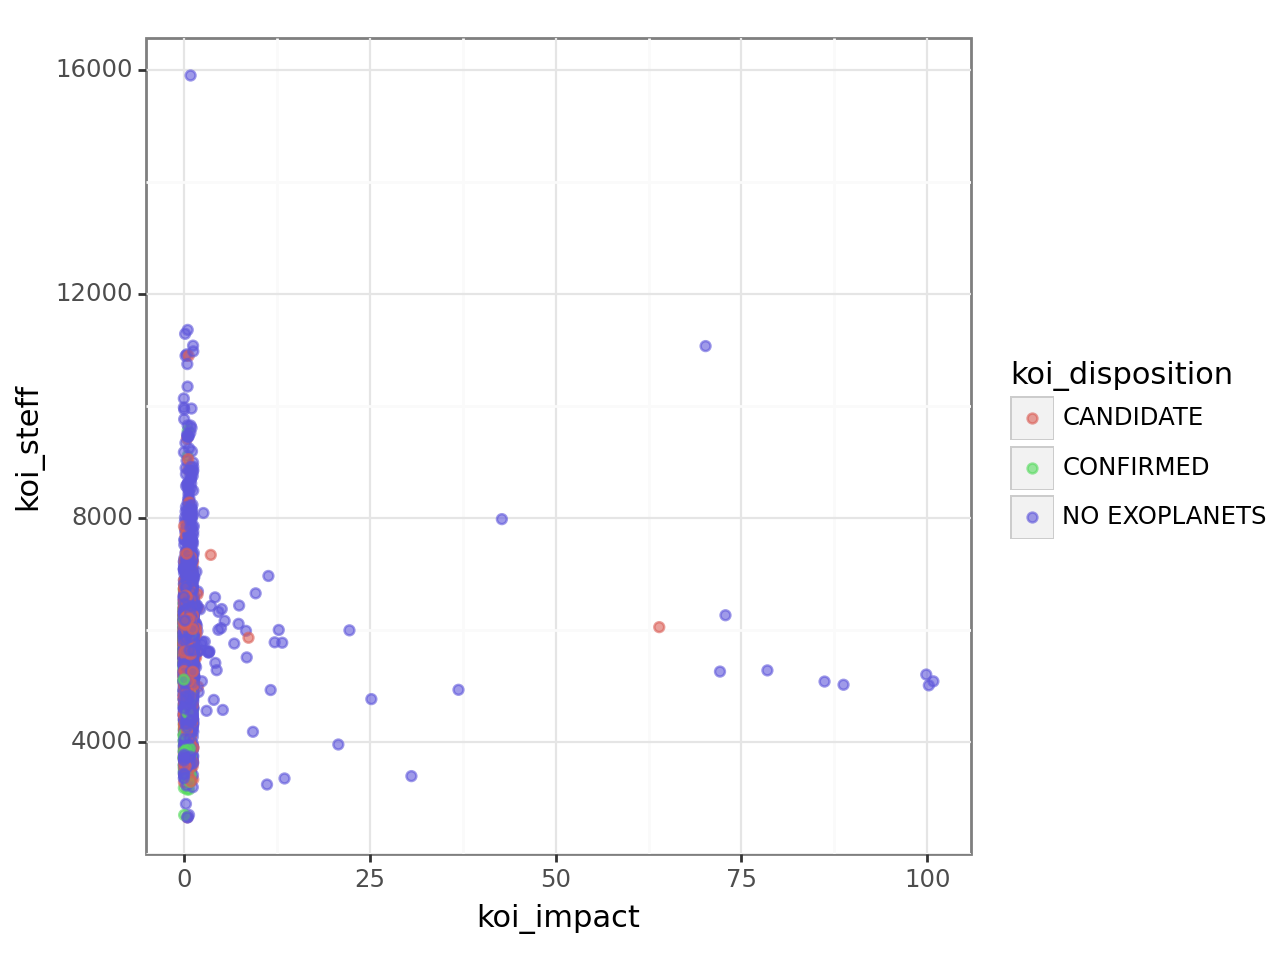

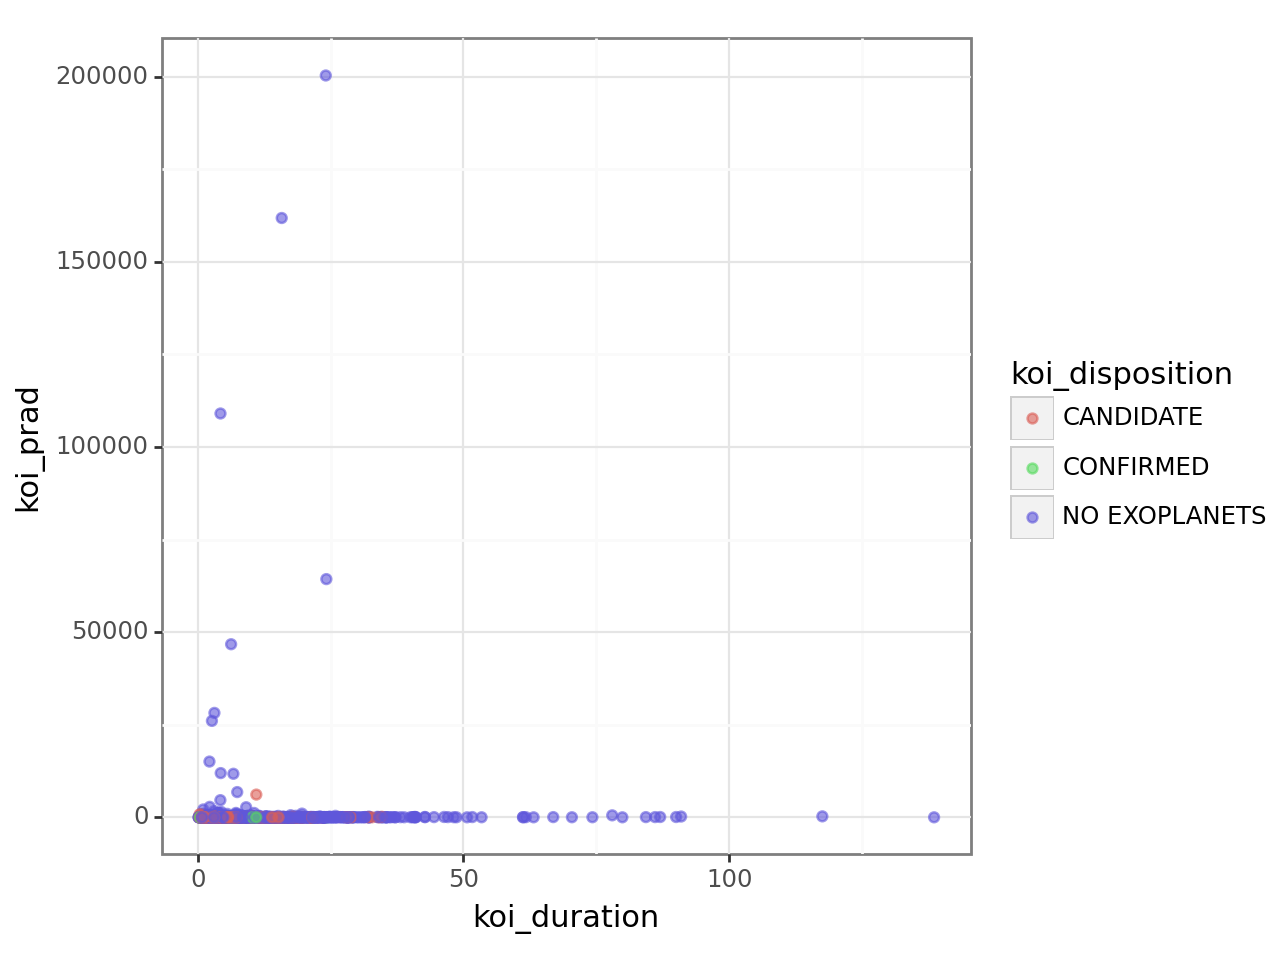

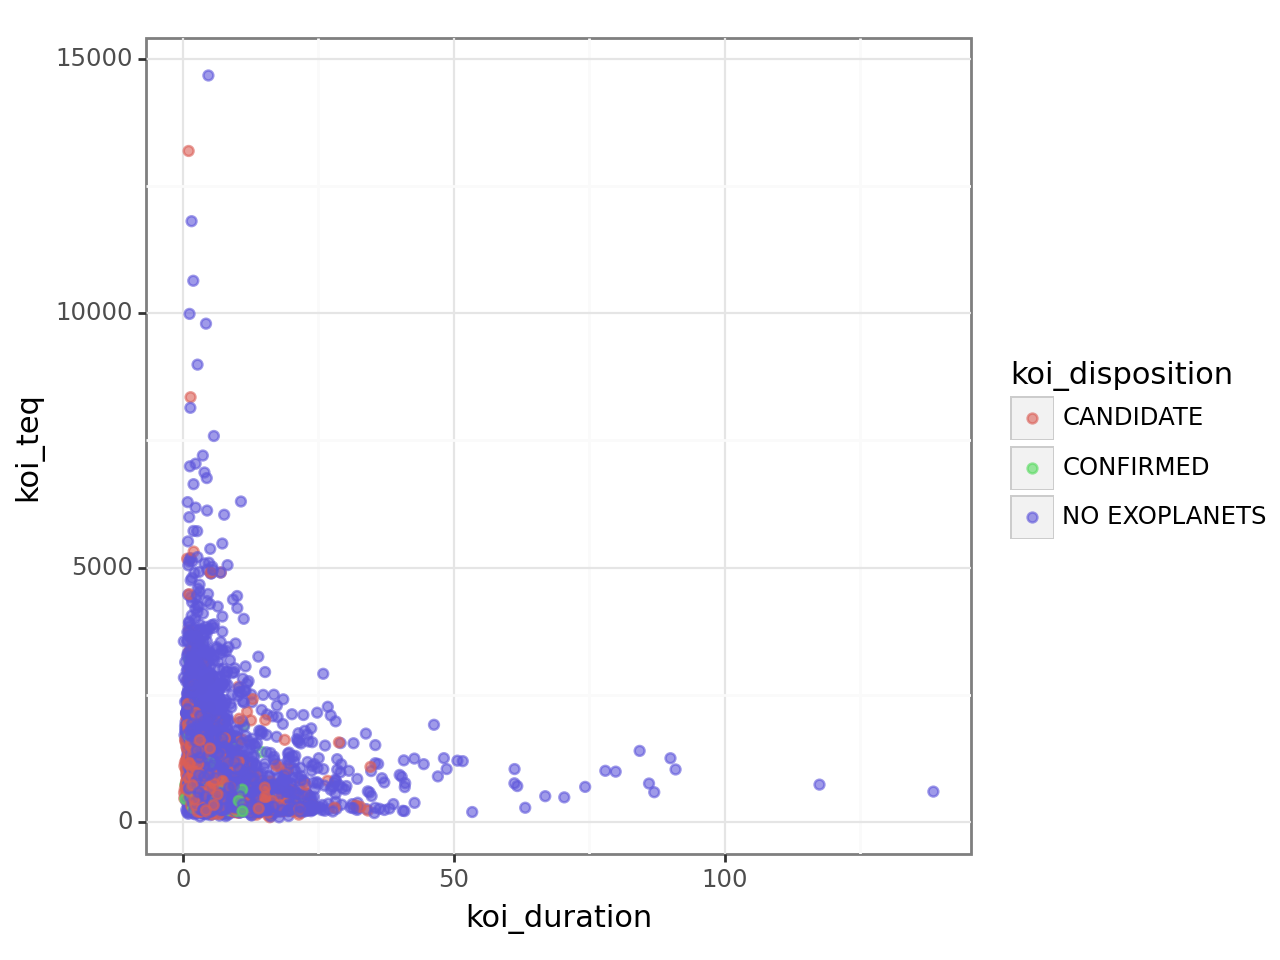

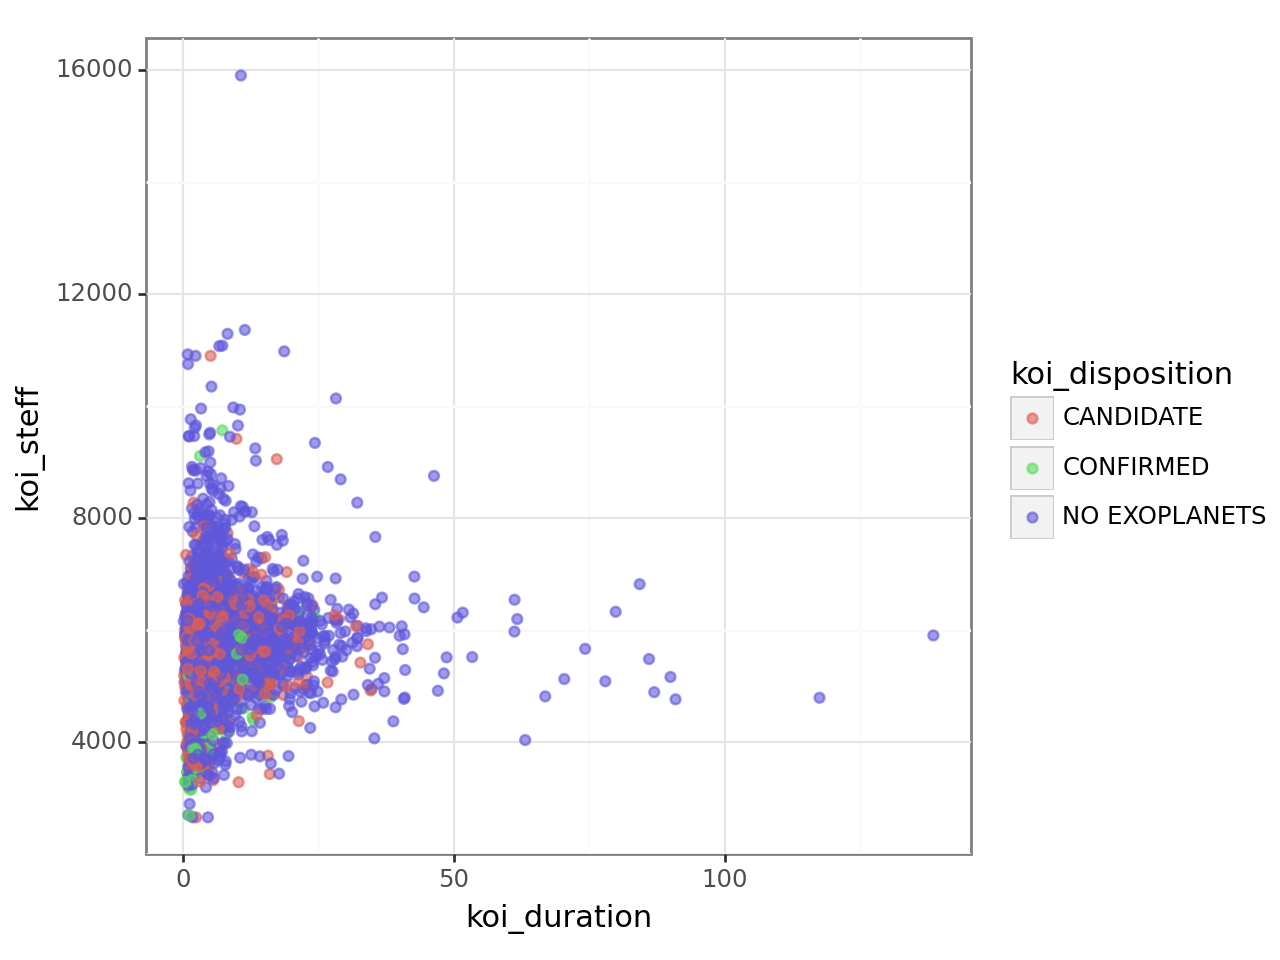

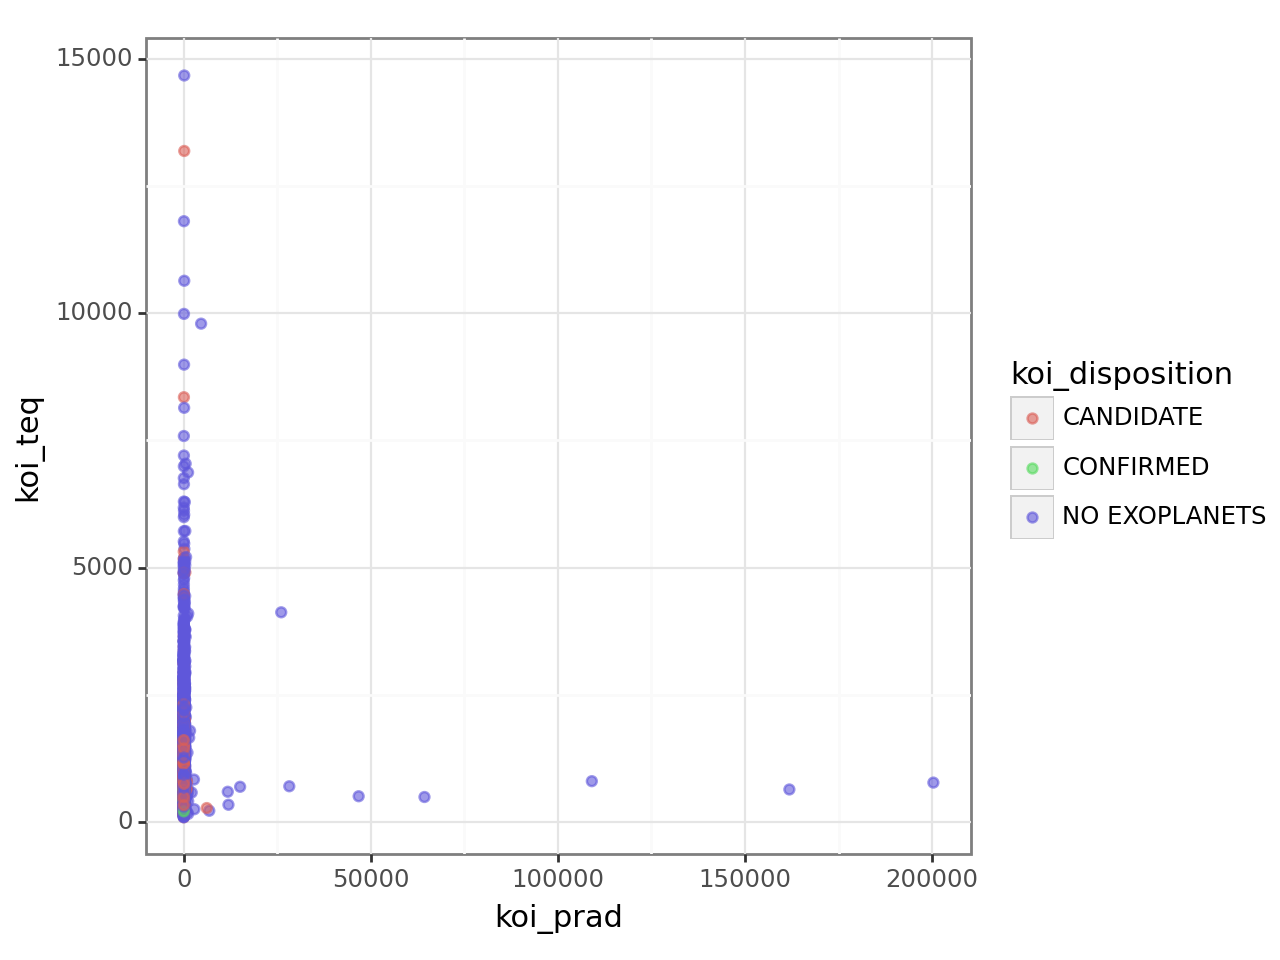

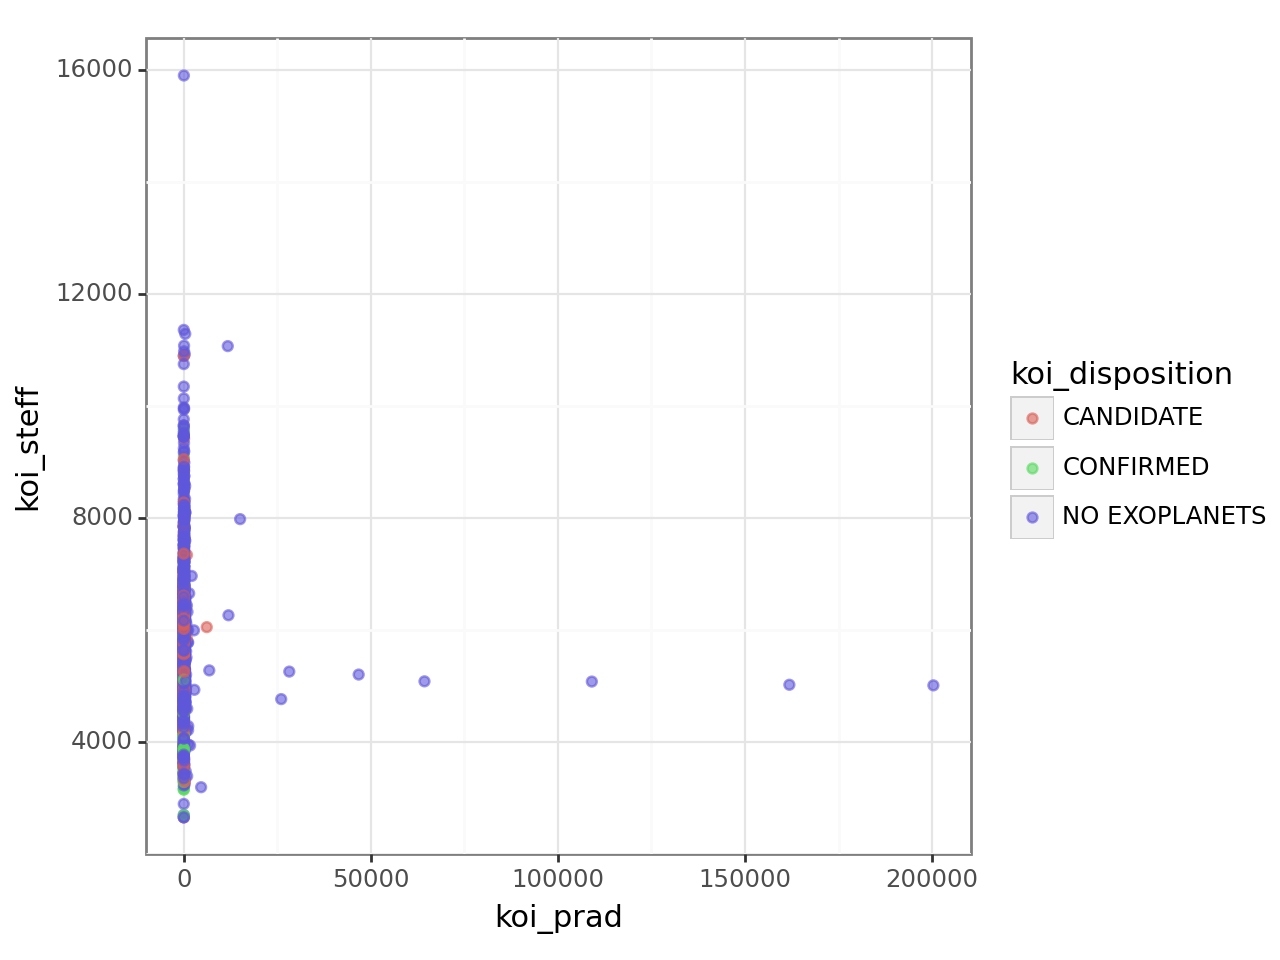

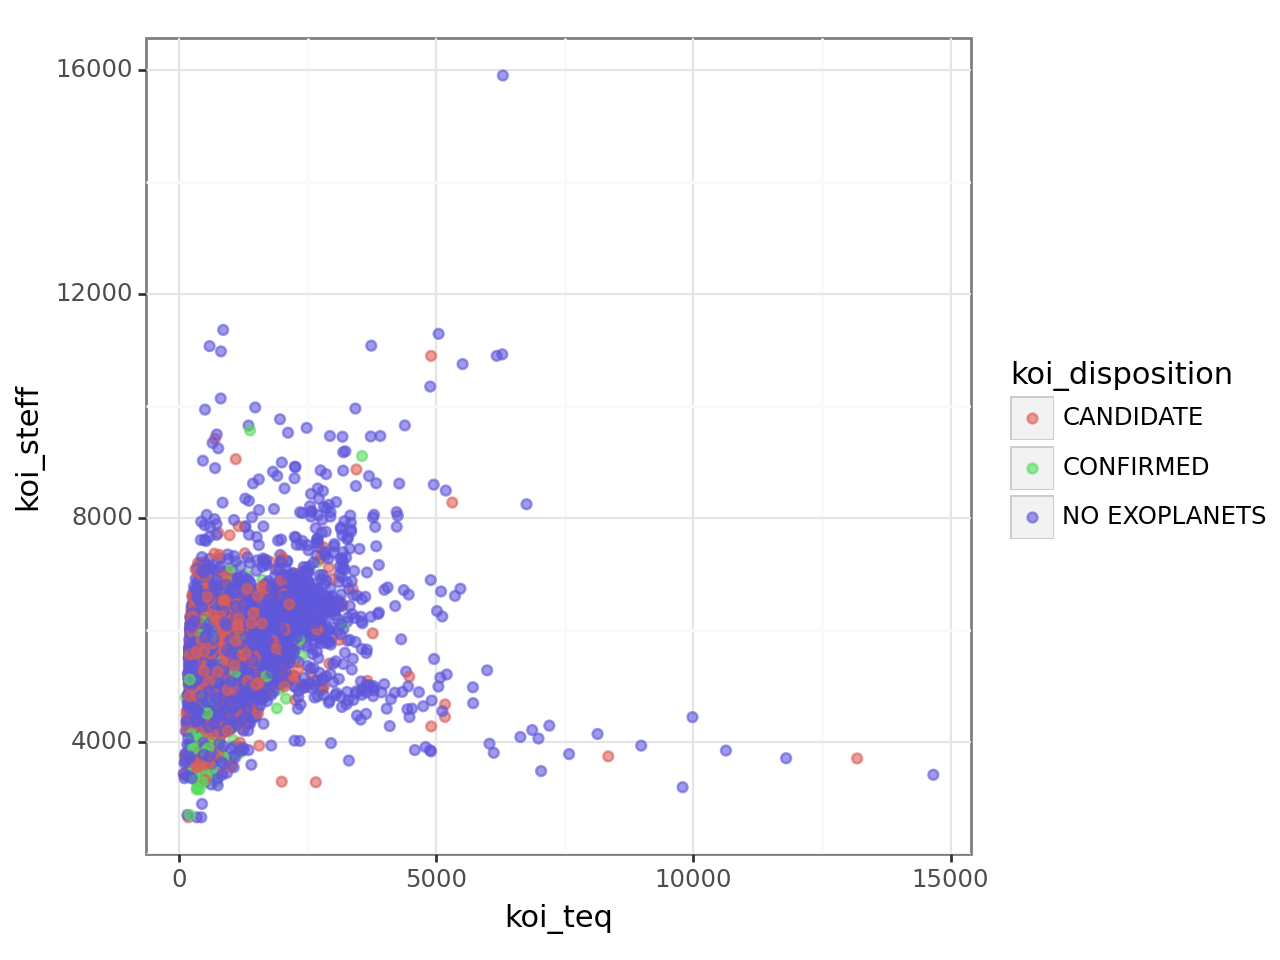

In [9]:
# Plots PCs según tipo de textura

labels = ['koi_period','koi_impact','koi_duration','koi_prad','koi_teq','koi_steff']

for label in combinations(labels,2):
    plot = ggplot(exoplanets)+aes(x=label[0],y=label[1],color='koi_disposition')+geom_point(alpha=0.6)+theme_bw()
    print(plot)

## Model building - Grid Search
Nos permite encontrar los mejores hyperparametros

In [11]:
# define the grid search parameters

# Function to create model, required for KerasClassifier
def create_model():
    # create model
    model = Sequential(name='Classification')
    model.add(tf.keras.layers.Input( shape=(X_train.shape[1],), name='Input' ))
    model.add(tf.keras.layers.Dense(units=40, 
                       activation='relu', 
                       name='HiddenLayer_1'))
    model.add(tf.keras.layers.Dense(units=3,
                       activation='softmax', kernel_regularizer=L1(0.0001),
                       name='output'))
    model.summary()
    return model


#model = KerasClassifier(model=create_model, loss="binary_crossentropy", epochs=100, batch_size=10, verbose=0)
model = KerasClassifier(model=create_model, loss="categorical_crossentropy", epochs=200, verbose=0)

optimizer = ['SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Adam', 'Adamax', 'Nadam']
batch = [10,20,40,80]

param_grid = dict(optimizer=optimizer, batch_size = batch)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Model: "Classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 HiddenLayer_1 (Dense)       (None, 40)                1640      
                                                                 
 output (Dense)              (None, 3)                 123       
                                                                 
Total params: 1763 (6.89 KB)
Trainable params: 1763 (6.89 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Best: 0.891476 using {'batch_size': 10, 'optimizer': 'Adam'}
0.833687 (0.021604) with: {'batch_size': 10, 'optimizer': 'SGD'}
0.884035 (0.003201) with: {'batch_size': 10, 'optimizer': 'RMSprop'}
0.791727 (0.021119) with: {'batch_size': 10, 'optimizer': 'Adagrad'}
0.541287 (0.049344) with: {'batch_size': 10, 'optimizer': 'Adadelta'}
0.891476 (0.006315) with: {'batch_size': 10, 'optimizer': 'Adam'}
0.880602 (0.0010

In [12]:
#Let us load the best model and predict on our input data
best_model = grid_result.best_estimator_
best_model


KerasClassifier(
	model=<function create_model at 0x000001E396241440>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=Adam
	loss=categorical_crossentropy
	metrics=None
	batch_size=10
	validation_batch_size=None
	verbose=0
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=200
	class_weight=None
)

In [13]:
#Let us load the best model and predict on our input data
best_model =grid_result.best_estimator_

# Predicting the Test set results
y_pred = best_model.predict(X_test)
y_pred

array([[0, 0, 1],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [0, 0, 1],
       [0, 1, 0]])

In [14]:
y_test_non_category = [ np.argmax(t) for t in y_test ]
y_predict_non_category = [ np.argmax(t) for t in y_pred ]


conf_mat = confusion_matrix(y_test_non_category, y_predict_non_category)

conf_mat

array([[306, 102,   8],
       [ 59, 417,  11],
       [  1,   0, 844]], dtype=int64)

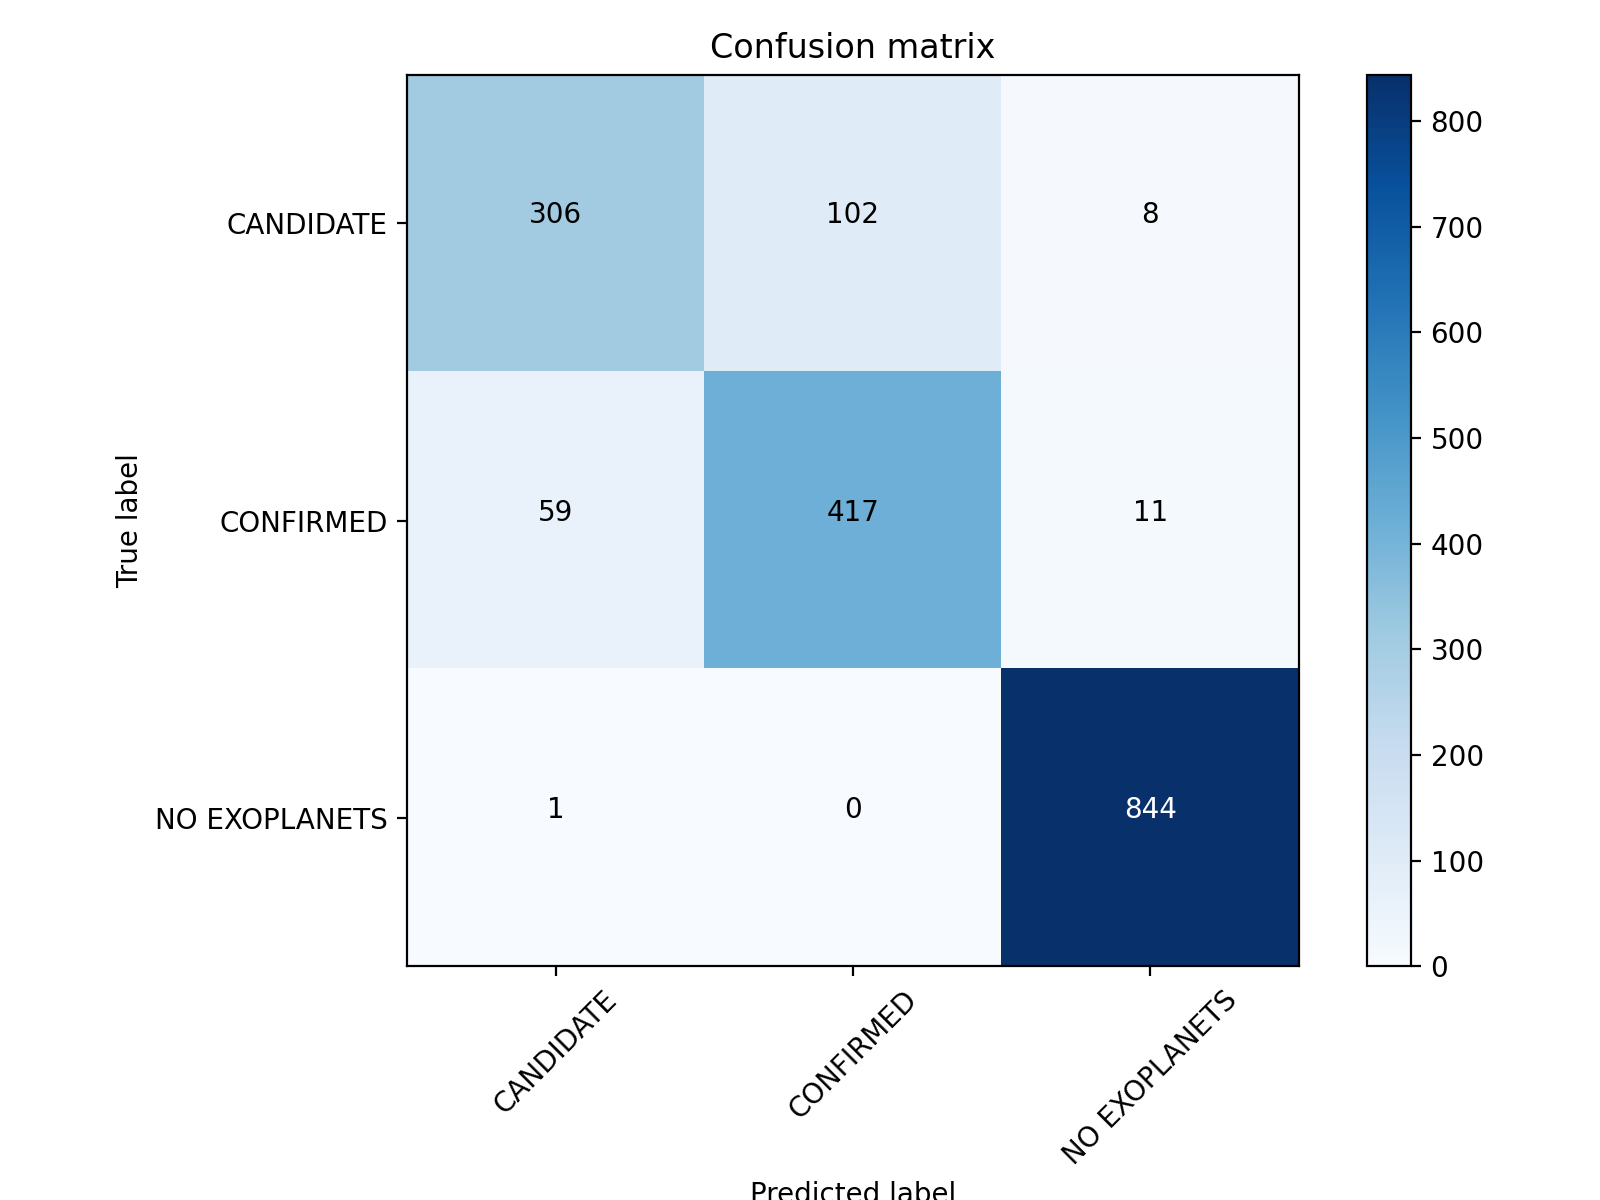

In [15]:
target_names =['CANDIDATE','CONFIRMED','NO EXOPLANETS']
plot_confusion_matrix(conf_mat, target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=False)

In [16]:
#Calcular F1_score : que es la media armonica entre precision y racall
from sklearn.metrics import f1_score
average='macro'
iaa_result = f1_score(y_test_non_category, y_predict_non_category, average=average)
print(f'F1 Score({average}): {round(iaa_result,2)}')
print('F1 Score (por Clase)', f1_score(y_test_non_category, y_predict_non_category, average=None))

F1 Score(macro): 0.87
F1 Score (por Clase) [0.7826087  0.82902584 0.9882904 ]
